<a href="https://colab.research.google.com/github/Jinzhao-Yu/BioStat615/blob/main/Jinzhao_Yu_BIOSTAT615_Midterm_Project_Fall_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jinzhao Yu - BIOSTAT615 Midterm Project - Fall 2022

## Introduction

This midterm project aims to implement methods to <u>***classify*** </u> and <u>***cluster***</u> widely known hand-written digit database, called MNIST database. 

This document describes how you can read MNIST dataset in R, and how you can implement your own classification and clustering tasks. 

To complete your midterm project, you will need to take the following steps:
1. Copy this document for your own version for editing
2. Rename the document title to start with your own name: for example "John Doe - BIOSTAT615 Midterm Project - Fall 2022".
3. Read this document carefully to understand what are required and recommended tasks
4. Complete the required (and optional) tasks
5. Write your own report in your copy of notebook directly
6. Share your copy of the notebook with instructors (hmkang@umich.edu , cywww@umich.edu) as viewers (***make sure that you do not share it with anyone else***), and submit the URL to the notebook in Canvas.

You should be able to use Markdown language to write your own report. See [Markdown Guide](https://colab.research.google.com/notebooks/markdown_guide.ipynb) to learn how to modify your copy of this report using Markdown. You may also want to read [LaTeX Tutorial](https://en.wikibooks.org/wiki/LaTeX/Mathematics) to learn how to write mathematical equations in your report. Alternatively, you may import equations as external images if you prefer.

***The parts you need to complete are underlined. <u>Please make sure that you filled in all underlined parts</u>***

## Background

This section introduces what the MNIST dataset looks like, and explains how you can use them for your project.

### Preambles

First, let's try to load some R packages we will use for some of the example exercises.

In [1]:
if (!require("tictoc")) {
    install.packages("tictoc")
}
library(ggplot2)
library(dplyr)
library(tictoc)

Loading required package: tictoc

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘tictoc’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Loading MNIST dataset

[MNIST](http://yann.lecun.com/exdb/mnist/) is a widely recognized databases of handwritten digits, containing thousands of labeled images in a standardized form. This data has been one of the gold-standard dataset to evaluate various machine learning methods. In this project, we will NOT require implement any machine learning or deep learning methods, but will use these data as an easy-to-visualize high-dimensional data. 

The code fragment below will load train (n=60,000) and test (n=10,000) images and labels (0 to 9), and visualize the images to improve your understanding. First, we will download these data from the web 

In [2]:
## DO NOT MODIFY THIS CELL
## set up the location of MNIST files
baseUrl = "http://yann.lecun.com/exdb/mnist/"
trainXf = "train-images-idx3-ubyte.gz"  ## train images
trainYf = "train-labels-idx1-ubyte.gz"  ## train labels
testXf = "t10k-images-idx3-ubyte.gz"    ## test images
testYf = "t10k-labels-idx1-ubyte.gz"    ## test labels

In [3]:
## DO NOT MODIFY THIS CELL
## Download MNIST data
filenames = c(trainXf, trainYf, testXf, testYf)
for(fn in filenames) { 
  if ( !file.exists(fn) ) { ## skip download if already exists
    system(paste0("wget ",baseUrl, fn),intern=TRUE)
  }
}

In [4]:
## DO NOT MODIFY THIS CELL
## verify the downloaded files
print(system("ls -l",intern=TRUE))
## Below is what you are expected to see when run this cell

[1] "total 11340"                                                           
[2] "drwxr-xr-x 1 root root    4096 Nov 18 14:34 sample_data"               
[3] "-rw-r--r-- 1 root root 1648877 Jul 21  2000 t10k-images-idx3-ubyte.gz" 
[4] "-rw-r--r-- 1 root root    4542 Jul 21  2000 t10k-labels-idx1-ubyte.gz" 
[5] "-rw-r--r-- 1 root root 9912422 Jul 21  2000 train-images-idx3-ubyte.gz"
[6] "-rw-r--r-- 1 root root   28881 Jul 21  2000 train-labels-idx1-ubyte.gz"


The download data is a binary file, and it follows a specific format described in the [original web site](http://yann.lecun.com/exdb/mnist/). To help you get started with this data, an example function to load this data is provided below. You do not have to understand how this function works. 

In [5]:
## DO NOT MODIFY THIS CELL
#' readMNIST() - Function to read MNIST images/labels
#' @param filename - Path to the local binary file
#' @return 1-d (label) or 3-d (images) arrays of MNIST data
readMNIST = function(filename) {
  con = gzfile(filename,"rb")
  hdr = readBin(con, integer(), n=2, endian="big") ## read one byte to figure out file type
  if ( hdr[1] == 2051 ) {         ## 2051 is a magic number for image files
    nxy = readBin(con, integer(), n=2, endian="big")  
    return ( array( readBin(con, integer(), signed=FALSE, size=1, n=hdr[2]*nxy[1]*nxy[2], endian="big"), dim=c(nxy[1],nxy[2],hdr[2]) ) )
  } else if ( hdr[1] == 2049 ) {  ## 2049 is a magic number for label files
    return ( readBin(con, integer(), signed=FALSE, size=1, n=hdr[2], endian="big") )
  } else {
    stop(paste0("Cannot recognize the magic number ", hdr[1]))
  }
}

In [6]:
## DO NOT MODIFY THIS CELL
train.X = readMNIST(trainXf)  ## read training images
train.Y = readMNIST(trainYf)  ## read training labels
print(dim(train.X))           ## print the dimension of training images (3-d array)
print(length(train.Y))        ## print the dimension of training labels

[1]    28    28 60000
[1] 60000


In [7]:
## DO NOT MODIFY THIS CELL
test.X = readMNIST(testXf)  ## read test images
test.Y = readMNIST(testYf)  ## read test labels
print(dim(test.X))          ## print the dimension of test images
print(length(test.Y))       ## print the dimension of test labels

[1]    28    28 10000
[1] 10000


     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]    0    0    0  177  253   47
[2,]    0    0    0   98  254   49
[3,]    0    0    0   56  250  116
[4,]    0    0    0    0  240  144
[5,]    0    0    0    0  198  150
[6,]    0    0    0    0  143  241


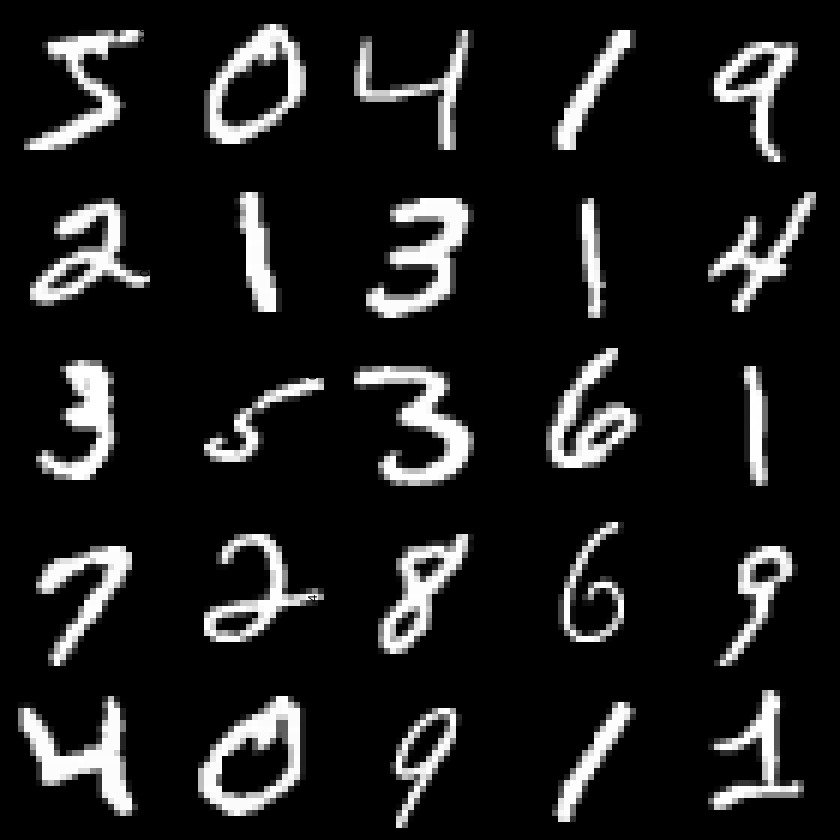

In [8]:
## DO NOT MODIFY THIS CELL
## quick sanity checking
print(train.X[10:15,20:15,3]) ## print some part of the large 3-d array
## draw first 25 images: note that the images are mirrored in columns
par(mfrow=c(5,5))
par(mar=c(0,0,0,0))
for(i in 1:25) { image(train.X[,28:1,i],col=gray((0:255)/255)) }

In [9]:
## DO NOT MODIFY THIS CELL
summary(train.X) ## show the summary of pixel-wise intensities
table(train.Y)   ## show the distribution of each digit

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   33.32    0.00  255.00 

train.Y
   0    1    2    3    4    5    6    7    8    9 
5923 6742 5958 6131 5842 5421 5918 6265 5851 5949 

## Task 1 : Classification of MNIST data

The first task is to implement an algorithm that performs classification of MNIST images. This task consists of two parts - (1) binary classification and (2) multi-class classification.

### Task 1a : Binary Classification of MNIST data

The binary classfication of MNIST data is outlined below. 

1. Subset images/labels that contains only two labels (you may select a pair of digits).
2. You are required to implement logistic Ridge regression by using the L-BFGS-B algorithm implemented in `optim()` function.
  * You need to comment your code well and write a brief documentation to explain how you implemented it.
  * The instructors will review your code and may provide specific comments. 

### Preparing input data for binary classification

The function below help you reshape the original data into a format that is easy to apply a binary classification algorithm. You are expected to specify a pair of digits as positive and negative labels. The function `prep_binary_classification()` returns a list containing a matrix `X` and a vector `y` as attributes. The matrix `X` has 784 (=28 x28) columns, and the number of rows equivalent to the number of positive + negative labels. The vector `y` is encoded as either 1 (for positive label) or 0 (for negative label) 

In [10]:
## DO NOT MODIFY THIS CELL
## prepare a model given a pair of digits
#' @param images - (r * c * n) array containing n images
#' @param labels - Size n vector of containing n labels
#' @param posLabel - The label(s) considered as positive label 
#' @param negLabel - The label(s) considered as negative label
#' @return A list containing then following attributes
#'         * X - Matrix of (nrow=number of selected labels, ncol=r*c)
#'         * y - Vector labels, encoded as zeros (negative) and ones (positive)
prep_binary_classification = function(images, labels, posLabel, negLabel) {
  dims = dim(images)
  X.pos = t(matrix(images[,,labels %in% posLabel],nrow=dims[1]*dims[2])) ## 784 * n1 matrix
  X.neg = t(matrix(images[,,labels %in% negLabel],nrow=dims[1]*dims[2])) ## 784 * n1 matrix
  return(list(X=rbind(X.pos, X.neg),y = c(rep(1,nrow(X.pos)),rep(0,nrow(X.neg)))))
}

In [11]:
## DO NOT MODIFY THIS CELL - IF YOU WANT TO CHANGE LABELS, USE TASK 1b.
## Subsample training and test datasets
trn = prep_binary_classification(train.X, train.Y, 1, 0)
tst = prep_binary_classification(test.X, test.Y, 1, 0)
## Check the dimensions of the data
print(dim(trn$X))
print(length(trn$y))
print(dim(tst$X))
print(length(tst$y))

[1] 12665   784
[1] 12665
[1] 2115  784
[1] 2115


#### ***TASK 1a : IMPLEMENT LOGISTIC RIDGE REGRESSION ON YOUR OWN*** (30 pts)

Let $\boldsymbol{x}_i$ be a row of `X`, and $\sigma(z) = \frac{1}{1+e^{-z}}$. Briefly, logistic Ridge regression will attempt to maximize the following penalized likelihood function.

$$
\log L(\boldsymbol{\beta},\lambda) = \frac{1}{n}\sum_{i=1}^n \left[y_i\log\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right) + (1-y_i)\log\left(1-\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right)\right) \right] - \frac{\lambda}{2n}\|\boldsymbol{\beta}\|_2^2
$$

which is equivalent to minimize $-\log L(\boldsymbol{\beta},\lambda)$. Some popular packages provide an easy way to perform this task. However, your task is to implement this algorithm yourself, utilizing numerical optimizations we learned from the class, without relying on external packages.

In this exercise below, to save the computational time, we will <u>train the model using the ***test*** data</u> instead of the training data because test data is smaller in size. We will evaluate the model across all train data.

The goal of the ***Task 1a*** is to implement logistic regression on your own. Here is a basic guideline.
* You need to implement `my.ridge.fit(X, y, lambda=1)` using only `base` and `stats` package.
* The function should return a list, including at least the following two attributes:
  * `par` : A vector of coefficients from logistic ridge regression with size `ncol(X)`
  * `counts` : A length 2 vector containing the number of evaluations of the objective functions and gradients.
  * Note that these attributes can be easily obtained from the output of `stats::optim()` function.  
* Using `stats::optim()` function with `L-BFGS-B` algorithm is highly recommended.
* Use $-\log L(\boldsymbol{\beta},\lambda)$ as the objective function and provide the gradient as needed.
* For this required task, you are not allowed to use external libraries beyond default R packages (e.g. `base`, `utils`, `stats`).

#### <u>Task 1a - PART I - DESCRIPTION OF YOUR IMPLEMENTATION (WRITE ON YOUR OWN)</u>

According to the penalized likelihood function above, we have to minimize $-logL(\beta,\lambda)$ and use the gradient descent method to find the optimal $\beta$. The derivation are as follows.
$$\sigma(z) = \frac{1}{1-e^{-z}} \Rightarrow \frac{d\sigma}{dz} = \sigma(z)(1-\sigma(z))$$
$$L = -logL(\beta,\lambda)=-\frac{1}{n}\sum_{i=1}^n[y_ilog\sigma(x_i^T\beta)+(1-y_i)log(1-\sigma(x_i^T\beta))]+\frac{\lambda}{2n}\lVert\beta\rVert_2^2$$
For each element $\beta_j$ in the vector $\beta$,
\begin{aligned}
\frac{dL}{d\beta_j} &= -\frac{1}{n}\sum_{i=1}^n[\frac{y_i}{\sigma(x_i^T\beta)}-\frac{1-y_i}{1-\sigma(x_i^T\beta)}]\frac{d\sigma(x_i^T\beta)}{d\beta_j}+\frac{\lambda\beta_j}{n}\\
&= -\frac{1}{n}\sum_{i=1}^n[\frac{y_i}{\sigma(x_i^T\beta)}-\frac{1-y_i}{1-\sigma(x_i^T\beta)}]\sigma(x_i^T\beta)(1-\sigma(x_i^T\beta))x_{ij}+\frac{\lambda\beta_j}{n}\\
&= -\frac{1}{n}\sum_{i=1}^n[y_i(1-\sigma(x_i^T\beta))-(1-y_i)\sigma(x_i^T\beta)]x_{ij}+\frac{\lambda\beta_j}{n}\\
&= -\frac{1}{n}\sum_{i=1}^n[y_i-\sigma(x_i^T\beta)]x_{ij}+\frac{\lambda\beta_j}{n}\\
\end{aligned}
Thus, the gradient function is, $$\frac{1}{n}\sum_{i=1}^n[\sigma(x_i^T\beta)-y_i]x_{ij}+\frac{\lambda\beta_j}{n}$$
In this question, since we have to use `optim` function, we have to implement the loss function $L$ and the gradient function above as the input parameters of `optim` function.

#### <u>Task 1a - PART II - ACTUAL IMPLEMENTATION </u>

_Fill in the code in the cell below. You may add additional cells if needed._

In [31]:
# sigmoid function
sigmoid = function(z){1/(1+exp(-z))}
# define a clip function to make sure loss is finite value
clip = function(x,min,max){
  return(pmin(pmax(min,pmax(x,pmin(x,min))),max))
}
# loss function L
Loss = function(X,y,beta,lambda){
  count1 <<- count1+1 # record the number of evaluations
  sigma = sigmoid(X%*%beta) # calculate the sigmoid function of each xi*beta
  sigma = clip(sigma,10^(-15),1-10^(-15)) # make sure that 10^(-15) <= sigma <= 1-10^(-15)
  n = length(y)
  L = (t(-y)%*%log(sigma)-t(1-y)%*%log(1-sigma))/n + lambda/(2*n)*t(beta)%*%beta # calculate the loss function
  return(L)
}
# gradient descent method
gradient = function(X,y,beta,lambda){
  count2 <<- count2+1 # record the number of evaluations
  sigma = sigmoid(X%*%beta) # calculate the sigmoid function of each xi*beta
  n = length(y)
  grad = (t(X)%*%(sigma-y))/n + (lambda/n)*beta # calculate the gradient function
  return(grad)
}

## TASK 1a: Implement my.ridge.fit() function that performs logistic regression
#' @param X - (n x p) matrix of predictor variables. Assume that intercept term is already included in the input.
#' @param y - A size n vector of zeros (negative) and ones (positives) as labels.
#' @return A list containing at least the following two attributes, which can be passed from stats::optim()
#'    * par - A size p vector of coefficients from logistic ridge regression.
#'    * counts - The number of function calls made on objective function and gradients.
#'    * You may include other attributes as you want.  
my.ridge.fit = function(X, y, lambda=1) {
  ## IMPLEMENT YOUR OWN FUNCTION HERE:
  ## * You may define other functions inside, or outside this function
  ## * Only base and stats packages are allowed. 
  ## * Using stats::optim() is highly recommended
  ## * Your objective function should be -log L(\beta,\lambda) in the equation above.
  ## * Note that you may have to deal with numerical precision challenges.
  count1 <<- 0
  count2 <<- 0
  m = ncol(X)
  # initialize beta as all 0's
  beta <- matrix(rep(0,m), nrow = m)
  # use 'optim' with L-BFGS-B algorithm
  res = optim(beta, fn = Loss, gr = gradient, method = "L-BFGS-B", X = X, y = y, lambda = lambda)
  # return coefficients and evaluation numbers
  return(list(par = res$par, counts = c(count1,count2))) ## Make sure to return a list
}

### Evaluation of TASK 1a

***DO NOT MODIFY the code fragment below.*** 

This code evaluates your output from your previous function. 

In [32]:
## DO NOT MODIFY THIS CELL
tic <- proc.time()
rst <- my.ridge.fit(tst$X, tst$y, 1) ## run the new method
toc <- proc.time()
cat(paste0("New ridge regression train took ",sprintf("%.5f",(toc-tic)[3])," seconds\n")) 
cat(paste0("Number of (function, gradient) evaluations: (",rst$counts[1],",",rst$counts[2],")\n")) 
## Example output is given below.

New ridge regression train took 3.18700 seconds
Number of (function, gradient) evaluations: (81,81)


In [33]:
## DO NOT MODIFY THIS CELL
## Evaluate the prediction accuracy using train data (as test data was used for training)
my.pred <- trn$X %*% rst$par 
## Tabulate the TP/FP/TN/FN
print(data.frame(pred=as.integer(my.pred > 0), true=trn$y) %>% count(true,pred) %>% mutate(freq=n/sum(n)))
## Example output is given below.
cat(paste0("Accuracy = ", sum(as.integer(my.pred > 0) == trn$y)/length(my.pred)), "\n")

  true pred    n         freq
1    0    0 5908 0.4664824319
2    0    1   15 0.0011843664
3    1    0    9 0.0007106198
4    1    1 6733 0.5316225819
Accuracy = 0.998105013817608 


_NOTE: The above output is merely an example, and it is okay not to have the same output. If your accuracy is much lower than above, you may need to improve it._

### Task 1a : Multi-class Classification of MNIST data

The multi-class classfication of MNIST data is outlined below. 

1. Subset images/labels that contains only two or more labels labels (you may select a group digits).
2. You are required to implement multi-class logistic Ridge regression by using the L-BFGS-B algorithm implemented in `optim()` function.
  * You need to comment your code well and write a brief documentation to explain how you implemented it.
  * The instructors will review your code and may provide specific comments. 

### Preparing input data for multi-class classification

The function below help you reshape the original data into a format that is easy to apply a 
multi-class classification algorithm. You are expected to specify a pair of digits as positive and negative labels. 

The function `prep_multi_classification()` returns a list containing matrices `X` and `Y` as attributes. 

The matrix `X` has 784 (=28 x28) columns, and the number of rows equivalent to the number of positive + negative labels, similar to the output from `prep_binary_classification()`. 

The matrix `Y` is a one-hot encoded matrix (i.e. `rowSum(Y) == 1`) to have value of `1` when the multi-class label matches with the column index.

In [12]:
## DO NOT MODIFY THIS CELL
## prepare data given a set of digits
#' @param images - (r * c * n) array containing n images
#' @param labels - Size n vector of containing n labels
#' @param selectedLabels - A vector of k labels considered for multi-class clustering  
#' @return A list containing then following attributes
#'         * X - matrix of (nrow=number of selected labels, ncol=r*c)
#'         * Y - (n * k) matrix of selected labels in one-hot encoding
prep_multi_classification = function(images, labels, selectedLabels) {
  dims = dim(images)
  idx = which(labels %in% selectedLabels)

  ## select images matching with selected labels and convert to matrix
  X = t(matrix(images[,,idx],nrow=dims[1]*dims[2])) ## 784 * n matrix
  n = nrow(X)   
  k = length(selectedLabels) 

  ## create one-hot encoded matrix Y
  matched_labels = match(labels[idx], selectedLabels)
  Y = matrix(0, n, k)
  Y[(matched_labels-1)*n + 1:n] <- 1    ## generate one-hot encoding matrix
  return(list(X=X, Y=Y))
}

#### ***TASK 1b : IMPLEMENT MULTI-CLASS CLASSIFICATION ON MNIST DATA*** (30 pts)

Define  

$$\boldsymbol{\tau}(\boldsymbol{z}) = \frac{e^{z}}{\sum_{i=1}^k e^{z_i}}$$

where $\boldsymbol{\tau}(\boldsymbol{z}) \in \mathbb{R}^k$ and $k$ is the number of labels for multi-class classification. 

Then we can define the penalized likelihood function of multiclass logistic regression in terms of $B \in \mathbb{R}^{p \times k}$.

$$L(B,\lambda) = 
\frac{1}{n}\sum_{i=1}^n \boldsymbol{y}_i^T\log \boldsymbol{\tau}\left(\boldsymbol{x}_i^T B\right) - \frac{\lambda}{2n}\|B\|_2^2
$$

where $\boldsymbol{x}_i \in \mathbb{R}^p$ is predictor variable and $\boldsymbol{y}_i \in \mathbb{R}^k$ is one-hot encoding of multi-class labels for $i$-th observation. 

The goal of the ***Task 1b*** is to implement multi-class logistic regression on your own. Here is a basic guideline.
* You need to implement `my.multi.fit(X, Y, lambda=1)` using only `base` and `stats` package.
* The function should return a list, including at least the following two attributes:
  * `par` : A `(p x k)` matrix of coefficients ($B$ in the equation above) from logistic ridge regression.
  * `counts` : A length 2 vector containing the number of evaluations of the objective functions and gradients.
  * Note that these attributes can be easily obtained from the output of `stats::optim()` function.  
* Using `stats::optim()` function with `L-BFGS-B` algorithm is highly recommended.
* Use $-\log L(\boldsymbol{B},\lambda)$ as the objective function and provide the gradient as needed.
* For this required task, you are not allowed to use external libraries beyond default R packages (e.g. `base`, `utils`, `stats`).

*Hint*: Because `optim()` function takes vector as argument, you need to pass $B$ as a vector, not as a matrix when using in objective and gradient functions, so some tweaking from the equation above may be necessary.  

#### <u>Task 1b - PART I - DESCRIPTION OF YOUR IMPLEMENTATION (WRITE ON YOUR OWN)</u>

For $B\in\mathbb{R}^{p\times k}$, we can derive it into $k$ vectors as $(\beta_1,\beta_2,\cdots,\beta_k)$. Then we can derive the loss function $-L(B,\lambda)$ as:
\begin{aligned}
L &= -\frac{1}{n}\sum_{i=1}^ny_i^Tlog(\frac{e^{x_i^T(\beta_1,\beta_2,\cdots,\beta_k)}}{\sum_{j=1}^ke^{x_i^T\beta_j}})+\frac{\lambda}{2n}\lVert B\rVert_2^2\\
&= -\frac{1}{n}\sum_{i=1}^n\sum_{j=1}^ky_{ij}log(\frac{e^{x_i^T\beta_j}}{\sum_{j=1}^ke^{x_i^T\beta_j}})+\frac{\lambda}{2n}\lVert B\rVert_2^2\\
&= -\frac{1}{n}\sum_{i=1}^n\sum_{j=1}^ky_{ij}[log(e^{x_i^T\beta_j})-log(\sum_{j=1}^ke^{x_i^T\beta_j})]+\frac{\lambda}{2n}\lVert B\rVert_2^2\\
&= -\frac{1}{n}\sum_{i=1}^n\sum_{j=1}^ky_{ij}[x_i^T\beta_j-log(\sum_{j=1}^ke^{x_i^T\beta_j})]+\frac{\lambda}{2n}\lVert B\rVert_2^2\\
\end{aligned}
Taking gradient with respect to $\beta_j$:
\begin{aligned}
\frac{dL}{d\beta_j} &=  -\frac{1}{n}\sum_{i=1}^n\sum_{j=1}^ky_{ij}(x_i^T - \frac{x_i^Te^{x_i^T\beta_j}}{\sum_{j=1}^ke^{x_i^T\beta_j}})+\frac{\lambda\beta_j}{n}\\
\end{aligned}

#### <u>Task 1b - PART II - ACTUAL IMPLEMENTATION </u>

_Fill in the code in the cell below. You may add additional cells if needed._

In [13]:
##########################################################
## PLEASE MODIFY THIS CELL (or Add more cells if needed)
##########################################################
## TASK 1a: Implement my.multi.fit() function that performs logistic regression
#' @param X - (n x p) matrix of predictor variables. Assume that intercept term is already included in the input.
#' @param Y - (n x k) matrix of one-hot encoding of multi-class labels
#' @return A list containing at least the following two attributes, which can be passed from stats::optim()
#'    * par - A size p vector of coefficients from logistic ridge regression.
#'    * counts - The number of function calls made on objective function and gradients.
#'    * You may include other attributes as you want.  
my.multi.fit = function(X, Y, lambda=1) {
  ## IMPLEMENT YOUR OWN FUNCTION HERE:
  ## * You may define other functions inside, or outside this function
  ## * Only base and stats packages are allowed. 
  ## * Using stats::optim() is highly recommended
  ## * Your objective function should be -log L(\beta,\lambda) in the equation above.
  ## * Note that you may have to deal with numerical precision challenges.
  ## * Note that you need to vectorize the matrix parameter B in the equation above.

  return(list(par=..., counts=..., ...)) ## Make sure to return a list
}

#### Task 1b - Evaluation

***WARNING: DO NOT MODIFY the code segments below.*** 

This code evaluates your output from your previous function. 

In [ ]:
## DO NOT MODIFY THIS CELL - IF YOU WANT TO CHANGE LABELS, USE TASK 1b.
## Subsample training and test datasets
#trn = prep_multi_classification(train.X, train.Y, c(0,1,2))
#tst = prep_multi_classification(test.X, test.Y, c(0,1,2))
selected.labels = c(0, 1, 7)
trn = prep_multi_classification(train.X, train.Y, selected.labels)
tst = prep_multi_classification(test.X, test.Y, selected.labels)
## Check the dimensions of the data
print(dim(trn$X))
print(dim(trn$Y))
print(dim(tst$X))
print(dim(tst$Y))

[1] 18930   784
[1] 18930     3
[1] 3143  784
[1] 3143    3


In [ ]:
## DO NOT MODIFY THIS CELL
tic <- proc.time()
rst <- my.multi.fit(tst$X, tst$Y, 1) ## run the new method
toc <- proc.time()
cat(paste0("New ridge regression train took ",sprintf("%.5f",(toc-tic)[3])," seconds\n")) 
cat(paste0("Number of (function, gradient) evaluations: (",rst$counts[1],",",rst$counts[2],")\n")) 
## Example output is given below.

New ridge regression train took 1.86600 seconds
Number of (function, gradient) evaluations: (34,34)


In [ ]:
my.pred <- selected.labels[apply(trn$X %*% rst$par, 1, which.max)]
true.pred <- selected.labels[apply(trn$Y, 1, which.max)]
print(table(my.pred))
## Tabulate the TP/FP/TN/FN
print(data.frame(pred=my.pred, true=true.pred) %>% count(true,pred) %>% mutate(freq=n/sum(n)))
## Example output is given below.

cat(paste0("Accuracy = ", sum(my.pred==true.pred)/length(my.pred)), "\n")

my.pred
   0    1    7 
6676 6827 5427 
  true pred    n         freq
1    0    0 5907 0.3120443740
2    0    1    5 0.0002641310
3    0    7   11 0.0005810882
4    1    0   78 0.0041204437
5    1    1 6616 0.3494981511
6    1    7   48 0.0025356577
7    7    0  691 0.0365029054
8    7    1  206 0.0108821976
9    7    7 5368 0.2835710512
Accuracy = 0.945113576333862 


#### <u>Task 1 - PART III - INTERPRET EVALUATION RESULTS (WRITE ON YOUR OWN)</u>

***Please delete the text in this cell and fill in with your own.***

_Briefly describe the followings: (it does not have to be long. 1-2 sentences each is fine.)_
* _Does your result make sense to you? What was most surprising to you?_
* _What was the challenging part in your implementation? How did you address the challenges?_
* _How could your implementation be potentially improved?_

## Task 2 : Clustering of MNIST data with Expectation-Maximization (E-M) algorithm

The second task is to implement an algorithm that performs multi-class clustering of MNIST images using the Expectation-Maximization algorithm.

1. Subset images/labels that contains 3 or more labels (to make the problem simple, but not too simple).
2. You are required to implement an E-M algorithm based on multivariate binomial distribution.
  * You need to comment your code well and write a brief documentation to explain how you implemented it.
  * The instructors will review your code and may provide specific comments. 

### Pre-task: Prepare the data for clustering

This section select a subset of labels from the test data (we work on test data rather than training to reduce response time), and cluster the corresponding images without using the labels at all. In this example, three labels - 0, 1, 7 are selected. 

In [14]:
## DO NOT MODIFY THIS CELL
## prepare data given a set of digits
#' @param images - (r * c * n) array containing n images
#' @param labels - Size n vector of containing n labels
#' @param selectedLabels - The label(s) considered for clustering  
#' @return A list containing then following attributes
#'         * X - Matrix of (nrow=number of selected labels, ncol=r*c)
#'         * y - Vector selected labels
prep_multiway_clustering = function(images, labels, selectedLabels) {
  dims = dim(images)
  idx = which(labels %in% selectedLabels)
  X = t(matrix(images[,,idx],nrow=dims[1]*dims[2])) ## 784 * n matrix
  return(list(X=X,y = labels[idx]))
}

In [15]:
## DO NOT MODIFY THIS CELL
## Select 3 labels for clustering
selected.labels = c(0, 1, 7)
tst = prep_multiway_clustering(test.X, test.Y, selected.labels)

### ***TASK 2: IMPLEMENT EM CLUSTERING ON YOUR OWN*** (40 pts)

The goal of the first project is to implement 3-class clustering. Here is a basic guideline.
* You need to implement `my.EM.clustering(X, nclust, max.iter, tol)` using only `base` and `stats` package.
* The function should return a list, including at least the following two attributes:
  * `mu` : A `ncol(X) * nclust` matrix of mean pixel strength (0-1 scale)  for each cluster. 
  * `est` : The best guess cluster of each image to one of the labels (i.e. in `1:nclust`). Note that the cluster id and the images labels do not have direct correspondence and may be permuted in different runs.
  
Here are useful guidelines to implement an E-M algorithm:
* Consider the image as if it is a binary data. For example, consider all pixels with value greater than 127 as 1, otherwise as zero. This allows us to model the image as 784(=28x28)-dimensional binary vectors.
* For convenience, ignore correlations between the dimensions, and model the conditional likelihood of data using independent Bernoulli random variables. For example, 
$$
\Pr(\boldsymbol{x}_i | \boldsymbol{\mu}) = \prod_{j=1}^p \mu_{j}^{x}(1-\mu_{j})^{1-x_i} 
$$
where $\boldsymbol{x}_i \in \{0,1\}^p$ is binarized input image, and $\boldsymbol{\mu} \in (0,1)^p$ is the parameters for a cluster, and $p$ is the dimension of input vector (e.g. 784). 
* The marginal likelihood of the data can be represented as a mixture of multiple components (clusters).
$$
\Pr(\boldsymbol{x}_i) = \sum_{k} \pi_k \Pr(\boldsymbol{x}_i | \boldsymbol{\mu}_k) 
$$
where $\pi_k$ represents mixing proportion of each component.
* Then, you may want to implement an E-M algorithm to infer $\boldsymbol{\mu}_1, \ldots, \boldsymbol{\mu}_K$ and other relevant parameters given observed data.

#### <u>Task 2 - PART I - DESCRIPTION OF YOUR IMPLEMENTATION (WRITE ON YOUR OWN)</u>

First, consider all pixels with values greater than 127 as 1, otherwise as 0, and this can cahnge an image into a $p$-dimensional binary vectors(in this problem, $p=784$). We consider a single multivariate random variable $x = (x_1,x_2, \cdots, x_p)$, and $\mu=(\mu_1,\mu_2,\cdots,\mu_p)$, which represent the input image binary vector and the univariate bernounlli distributed parameters. And then we can model the conditional likelihood,
$$Pr(x|\mu)=\prod_{j=1}^p \mu_j^{x_j}(1-\mu_j)^{1-x_j}$$
Since we have to model multiple clusters, suppose we have a mixture of $K$ Bernoulli distributions, and each cluster has a set of parameters $\mu^{(k)}=(\mu_1^{(k)},\mu_2^{(k)},\cdots,\mu_p^{(k)})$, and a mixing proportion $\pi_k$. And then the log-likelihood could be derived as:
$$log(Pr(x|\mu,\pi))=log(\sum_{k=1}^KI(x\text{ is drawn form cluster }k)Pr(x|\mu^{(k)}))=log(\sum_{k=1}^K\pi_kPr(x|\mu^{(k)}))$$
The likelihood above is for just a data point(or one image only), and now we have $N$ images inputs $X=(x^{(1)},\cdots,x^{(N)})$, thus the log-likelihood function is,
$$log(Pr(X|\mu,\pi))=log(\prod_{n=1}^NPr(x^{(n)}|\mu,\pi))=\sum_{n=1}^Nlog(\sum_{k=1}^K\pi_kPr(x^{(n)}|\mu^{(k)}))$$
Now, in order to maximize the log likelihood function, we use E-M algorithm and the first thing is to introduce the latent variables $Z = (z^{(1)},\cdots,z^{(N)})$, and $z^{(n)}=(z_1^{(n)},\cdots,z_K^{(n)})$ for $K$ different clusters,
$$Pr(z^{(n)}|\pi)=\prod_{k=1}^K\pi_k^{z_k^{(n)}},Pr(x^{(n)}|z^{(n)},\mu,\pi)=\prod_{k=1}^K(Pr(x^{(n)}|\mu^{(k)}))^{z_k^{(n)}}$$
Thus, the conditional log-likelihood funtion of $X$ and $Z$ could be derived as,
\begin{aligned}
log[Pr(X,Z|\mu,\pi)] &= log\left[\prod_{n=1}^NPr(x^{(n)}|z^{(n)},\mu,\pi)Pr(z^{(n)}|\pi)\right]\\
&=log\left\{\prod_{n=1}^N\left[\prod_{k=1}^K(Pr(x^{(n)}|\mu^{(k)}))^{z_k^{(n)}}\right]\left[\prod_{k=1}^K\pi_k^{z_k^{(n)}}\right]\right\}\\
&=\sum_{n=1}^N\left[\sum_{k=1}^Kz_k^{(n)}log[Pr(x^{(n)}|\mu^{(k)})]+\sum_{k=1}^Kz_k^{(n)}log\pi_k\right]\\
&=\sum_{n=1}^N\sum_{k=1}^Kz_k^{(n)}\left[log[Pr(x^{(n)}|\mu^{(k)})]+log\pi_k\right]\\
&=\sum_{n=1}^N\sum_{k=1}^Kz_k^{(n)}\left[log\left[\prod_{j=1}^p(\mu_j^{(k)})^{x_j^{(k)}}(1-\mu_j^{(k)})^{(1-x_j^{(k)})}\right]+log\pi_k\right]\\
&=\sum_{n=1}^N\sum_{k=1}^Kz_k^{(n)}\left[\sum_{j=1}^p\left[{x_j^{(k)}}log(\mu_j^{(k)})+{(1-x_j^{(k)})}log(1-\mu_j^{(k)})\right]+log\pi_k\right]
\end{aligned}
Also, we can have the expectation of latent variables,
$$\eta(z_k^{(n)})=E\left[z_k^{(n)}|x^{(n)}\mu,\pi\right]=Pr\left[z_k^{(n)}=1|x^{(n)},\mu,\pi\right]=\frac{\pi_k\prod_{j=1}^p(\mu_j^{(k)})^{x_j^{(k)}}(1-\mu_j^{(k)})^{(1-x_j^{(k)})}}{\sum_{k=1}^K\pi_k\prod_{j=1}^p(\mu_j^{(k)})^{x_j^{(k)}}(1-\mu_j^{(k)})^{(1-x_j^{(k)})}}$$
For the M-step, in order to maximize the log-likelihood function with respect to the posterior distribution of latent variable $\eta(z_k^{(n)})$, set the derivative to 0 and solve the equation,
$$\frac{d}{d\mu_j^{(k)}}E_Z\left[log(Pr(X,Z|\mu,\pi))\right]=\sum_{n=1}^N\eta(z_k^{(n)})\left[\frac{x_j^{(n)}}{\mu_j^{(k)}}+\frac{1-x_j^{(n)}}{1-\mu_j^{(k)}}\right]=0$$
$$\mu_j^{(k)}=\frac{\sum_{n=1}^N\eta(z_k^{(n)})x_j^{(n)}}{\sum_{n=1}^N\eta(z_k^{(n)})}$$
Meantime, we have also to find the $\pi_k$ to maximize the log-likelihood function, with a contraint of $\sum_{k=1}^K\pi_k=1$ since it is the mixing proportion, keeping the $\mu_j^{(k)}$ as the result above:
$$\frac{d}{d\pi_k}\left[-\sum_{n=1}^N\sum_{k=1}^K\eta(z_k^{(n)})log\pi_k+\lambda(\sum_{k=1}^{K}\pi_k-1)\right]=0$$
$$-\sum_{n=1}^N\frac{\eta(z_k^{(n)})}{\pi_k}+\lambda=0\Rightarrow\pi_k=\frac{\sum_{i=1}^N\eta(z_k^{(n)})}{\lambda}$$
Now we are going to solve the value of $\lambda$, with the same method, setting the derivative to 0,
$$\frac{d}{d\lambda}\left[-\sum_{n=1}^N\sum_{k=1}^K\eta(z_k^{(n)})(log[\sum_{i=1}^N\eta(z_k^{(n)})]-log\lambda)+\left(\sum_{k=1}^K\sum_{i=1}^N\eta(z_k^{(n)})-\lambda\right)\right]=0$$
$$\frac{1}{\lambda}\sum_{n=1}^N\sum_{k=1}^K\eta(z_k^{(n)})-1=0\Rightarrow\lambda=\sum_{n=1}^N\sum_{k=1}^K\eta(z_k^{(n)})$$
Thus,
$$\pi_k=\frac{\sum_{i=1}^N\eta(z_k^{(n)})}{\sum_{n=1}^N\sum_{k=1}^K\eta(z_k^{(n)})}$$
For the implentation of this algorithm, we have to calculate $\eta(z_k^{(n)})$ in the E-step, and update $\mu$ and $\pi$ in the M-step, and since we have to keep evey elements of $\mu$ and $\pi$ positive to avoid infinite value, we can add a tolerance (1e-100). In each iteration, we will do the E-step and M-step, and calculate the log-likelihood function, then compare the difference between 2 likelihood with the tolerance, if the difference is enough small, we can regard it as converged, and return the optimal solutions.\
For the initialization, $\mu$ is randomly sampled from Uniform distribution(0,1), and normalized each column. $\pi$ is equally selected as $\frac{1}{K}$.

#### <u>Task 2 - PART II - ACTUAL IMPLEMENTATION </u>

_Fill in the code below. You may add additional cells if needed._

In [21]:
##########################################################
## PLEASE MODIFY THIS CELL (or Add more cells if needed)
##########################################################
## Implement your own clustering algorithm

# E-step
Estep = function(X,mu,p){ # X as input data, mu as parameters, p as pi(proportion)
   log_eta <<- matrix(0, nrow = nrow(X),ncol = K)
   log_eta <<- X%*%t(log(mu))+(1-X)%*%t(log(1-mu)) # log-eta values
   for (i in 1:K){
     log_eta[,i] = log_eta[,i] + log(p[i]) # for each column add a same pi value for log
   }
   max_log_eta <<- apply(log_eta, 1, max)
   eta <<- exp(sweep(log_eta, 1, max_log_eta)) # each row minus the max value of the row
   sum_eta <<- apply(eta, 1, sum)
   eta <<- t(t(eta)/sum_eta) # normalize the eta matrix
   logL <<- sum(max_log_eta+log(sum_eta)) # log-likelihood function
}
# M-step
Mstep = function(X,eta){
  sum_eta_col = apply(eta, 2, sum)
  # update mu and pi, avoid infinite value
  mu <<- (t(eta)%*%X)/sum_eta_col + 1e-100*ncol(eta)
  p <<- sum_eta_col/sum(sum_eta_col) + 1e-100
}
# check convergence
check.tol = function(fmax,fmin,ftol){
  delta = abs(fmax - fmin)
  accuracy = (abs(fmax) + abs(fmin))*ftol
  return(delta < (accuracy + tol))
}

#' @param X : (n * 784) matrix of images (binarizing the matrix at X[i,j] > 127 is highly recommended)
#' @param nclust : Number of clusters to generate
#' @param max.iter : Maximum number of iteration, may end early based on convergence criteria
#' @param tol : Parameters for determining convergence.
#' @return A list containing at least the following attributes:
#'    * mus - A [ ncol(X) * nclust ] matrix of mean pixel strength (0-1 scale)  for each cluster.
#'    * est - The best guess cluster of each image to one of the labels (i.e. in `1:nclust`). 
my.EM.clustering = function(X, nclust, max.iter, tol) {
  set.seed(680)
  # convert input data to binary vectors
  X[X<=127] <- 0
  X[X>127] <- 1
  K <<- nclust
  max_iter = 1000L
  tol <<- 1e-6
  loglik_tol <<- 1e-6
  loglik_list = NULL
  # initialization
  p <<- rep(1.0/K, length = K)
  N = nrow(X)
  M = ncol(X) # in the equation above M = p
  mu <<- matrix(0, nrow = K, ncol = M)
  for (i in 1:M){
    mu[,i] <<- runif(K)
    mu[,i] <<- mu[,i]/sum(mu[,i])
  }
  logL <<- -Inf
  convergence = 0
  # E-M algorithm
  for (iter in 1:max_iter){
    loglik0 <- logL # temperate variable to save last log-likelihood function
    Estep(X, mu, p)
    Mstep(X, eta)
    loglik_list = c(loglik_list, logL) # save the log-likelihood function values
    if (check.tol(loglik0, logL, loglik_tol)){
      convergence = 0 # converged
      break
    }
  }
  mus = t(mu)
  Estep(X, mu, p)
  est <- apply(eta, 1, which.max)
  ## Make sure to return at least two attributes (or more)
  return(list(mus=mus,est=est,convergence=convergence,mu=mu,p=p,loglik_list=loglik_list,iter=iter))
}

### Evaluation of TASK 2

***DO NOT MODIFY The code fragment below.***

This code evaluates your output from your previous function. 

In [22]:
## DO NOT MODIFY THIS CELL
## Run the clustering algorithm from the selected Data
tic()
rst = my.EM.clustering(tst$X,length(selected.labels))
toc()
## NOTE: This step took 2.894 seconds from a working example with an E-M algorithm

3.082 sec elapsed


NULL

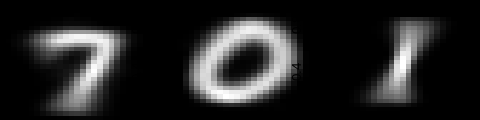

In [23]:
## DO NOT MODIFY THIS CELL
## Visualize rst$mus as images.
options(repr.plot.width=4, repr.plot.height=1)
par(mfrow=c(1,3))
par(mar=c(0,0,0,0))
apply(rst$mus,2,function(x) { image(matrix(x,28,28)[,28:1]*255,col=gray((0:255)/255)) })
## below is a result from a working example with an E-M algorithm

In [24]:
## DO NOT MODIFY THIS CELL
## Tabulate the contingency tables to understand the accuracy 
print(data.frame(est=rst$est, true=tst$y) %>% count(true,est) %>% mutate(freq=n/sum(n)))
## below is a result from a working example with an E-M algorithm

  true est    n         freq
1    0   1   10 0.0031816736
2    0   2  968 0.3079860006
3    0   3    2 0.0006363347
4    1   1   29 0.0092268533
5    1   2    4 0.0012726694
6    1   3 1102 0.3506204263
7    7   1  943 0.3000318167
8    7   2   33 0.0104995227
9    7   3   52 0.0165447025


_Note that the results above are based on a suggestive implementation, and you do not have to have exactly the same results (but comparable results are expected to obtain full credit)_

#### <u>Task 2 - PART III - INTERPRET EVALUATION RESULTS (WRITE ON YOUR OWN)</u>

* _Did your E-M algorithm always converge to the intended solution or not? Why or why not?_ \
Since the E-M algorithm never decrease the log-likelihood, thus it will always converge to an optimal solution. However, it converegs to a local optimal solution, so we can not make sure that it will converge to intended solution.
* _Does your result make sense. What surprise you the most?_ \
My result makes sense obviously. The visualiztion of the result can clearly show  the shape of 3 different digits, and the accuracy of the result (7-1,0-2,1-3) reaches over 95%, which surprises me the most. Also, I find that the proportion of wrong classification  of differnent digits is not the same, and in my result, digit '7' has the highest probability to be wrongly classified.
* _What was the tricky part in your implementation? How did you address the challenges?_ \

* _How could your implementation be potentially improved?_

### ***TASK 3: IMPROVE THE METHODS ABOVE*** (optional for extra credit)

This is an open-ended task. You are encouraged to perform additional follow-ups on classification & clustering tasks above. Examples include the following:
  * (Easy) Try different sets of labels to understand the data-dependent differences in the classification/clustering performance. Also, try to evaluate the robustness of your algorithm based on different initial points.
  * (Medium) Identify issues with current implementations and try to find a way to improve the algorithm, in terms of accuracy or numerical stability.
  * (Hard) Try to implement another algorithm and compare the performance between the algorithms. Describe which ones are better in which cases and justify your answer.

Add additional code or text cells as needed below. Make sure to include your brief report on your work so that instructors can understand what you accomplished clearly.

For this optional task, you are allowed to use any external libraries if needed.

In [ ]:
##########################################################
## PLEASE MODIFY THIS CELL (or Add more cells if needed)
## To perform TASK 3 (optional)
##########################################################